In [1]:
import pysam
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import scipy.stats
import pybedtools as pybed

from utils.vcf_tools_eam0 import *
#from utils.plot_tools_eam import *


sns.set_style('ticks')
pd.set_option('display.max_columns', None)



In [2]:

## Read metadata files

samples_Illum610K = ["scz_asrb_eur-qc", "scz_lacw_lemu_eur_qc"]
samples = samples_Illum610K
studyName=  "Illum_610K"


#met_data = pd.read_csv('../data/metadata/Illum610K_sample_info_20190603_unix.txt', sep="\t")
met_data = pd.read_table('../data/metadata/Illum610K_sample_info_20190603_unix.txt',sep="\t")
met_data.reset_index(inplace=True)
met_data.alt_identifier.loc[met_data.alt_identifier.isna()] =\
    met_data.identifier.loc[met_data.alt_identifier.isna()].values
met_data.drop_duplicates(subset="alt_identifier",inplace=True)


met_study = met_data.copy()
met_dx = met_study[met_study.case_control == "SCZ"]
met_ctrl = met_study[met_study.case_control=="CONT"]

met_failedQC = met_study[met_study.FailedQC == True] #failed PGC QC



/home/emauryg/anaconda3/envs/bsmn3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [3]:

#############################################
## read mocha results
#############################################
df = pd.DataFrame()


stats = pd.DataFrame()
nsum=0
for s in samples:
  print(s)
  df_temp = pd.read_table('../data/mocha_calls/{}.calls.tsv'.format(s))
  df_temp['batch'] = s
  df = df.append(df_temp)
  stats_temp = pd.read_table('../data/mocha_calls/{}.stats.tsv'.format(s))
  stats_temp['batch'] = s
  stats = stats.append(stats_temp)



df = df.rename(str.upper, axis="columns")
stats = stats.rename(str.upper, axis="columns")
df.TYPE[df.TYPE == "CN-LOH"] = "CNN-LOH"
df = df.rename(columns={"SAMPLE_ID":"SAMPLE",\
  "BEG_GRCH37":"BEG_GRCh37", "END_GRCH37":"END_GRCh37", "N_HETS":"NHETS","BATCH":"batch"})
df = df.replace(".zip","",regex=True)
df.CHROM = df.CHROM.astype(str)
df.SAMPLE = df.SAMPLE.astype(str)
df.loc[df.BDEV.isna(), 'BDEV']=0
stats = stats.rename(columns={"SAMPLE_ID":"SAMPLE",\
  "BEG_GRCH37":"BEG_GRCh37", "END_GRCH37":"END_GRCh37", "N_HETS":"NHETS","BATCH":"batch"})
df.TYPE[df.TYPE == "Gain"] = "Duplication"
df.TYPE[df.TYPE == "Loss"] = "Deletion"

id_table = met_data.copy()
id_table.set_index('alt_identifier',inplace=True)
## This samples were not present in the master table
df = df.loc[~(df.SAMPLE.isin(pd.Series(['WG0057057-DNAC04', 'WG0057057-DNAG12'])))]
df["arrayName"] =  id_table.loc[df.SAMPLE,"Array"].values

df["FailedQC"] = 0
df.loc[(df.SAMPLE.isin(met_failedQC.alt_identifier)) | (df.SAMPLE.isin(met_failedQC.identifier))] = 1

df_dx = df[(df.SAMPLE.isin(met_dx.alt_identifier)) | (df.SAMPLE.isin(met_dx.identifier))]
df_ctrl = df[df.SAMPLE.isin(met_ctrl.alt_identifier) | (df.SAMPLE.isin(met_ctrl.identifier))]
df = pd.concat([df_dx,df_ctrl])


scz_asrb_eur-qc
scz_lacw_lemu_eur_qc


/home/emauryg/anaconda3/envs/bsmn3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/emauryg/anaconda3/envs/bsmn3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/emauryg/anaconda3/envs/bsmn3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
stats.head()

,SAMPLE,COMPUTED_GENDER,CALL_RATE,LRR_MEDIAN,LRR_SD,LRR_AUTO,BAF_SD,BAF_CONC,BAF_AUTO,N_SITES,NHETS,X_NONPAR_N_HETS,X_NONPAR_BAF_CORR,X_NONPAR_LRR_MEDIAN,Y_NONPAR_LRR_MEDIAN,MT_LRR_MEDIAN,LRR_GC_REL_ESS,LRR_GC_0,LRR_GC_1,LRR_GC_2,batch
0,100103,M,0.9999,0.0165,0.1243,0.0173,0.0189,0.5023,0.0146,576127,180089,0,NaN,-0.044,NaN,NaN,0.0911,0.6013,-2.3614,2.2087,scz_asrb_eur-qc
1,100104,M,0.9996,-0.0115,0.1565,0.0175,0.0226,0.5049,0.0140,576133,180239,1,NaN,-0.119,NaN,NaN,0.0222,-0.4998,2.1058,-2.1677,scz_asrb_eur-qc
2,100105,M,0.9997,-0.0140,0.1518,0.0108,0.0240,0.5020,0.0108,576106,179282,1,NaN,-0.135,NaN,NaN,0.0328,-0.4675,1.8824,-1.8334,scz_asrb_eur-qc
3,100106,F,0.9999,0.0190,0.1423,0.0201,0.0186,0.5003,0.0032,576114,184305,4372,0.0171,0.243,NaN,NaN,0.0901,0.7162,-2.8489,2.7159,scz_asrb_eur-qc
4,100108,M,0.9999,0.0140,0.1167,0.0158,0.0191,0.5024,0.0065,576122,183512,1,NaN,-0.055,NaN,NaN,0.0106,0.2604,-1.0311,1.0178,scz_asrb_eur-qc


In [5]:
###############################
## Add sample-wide statistics
###############################

stats.SAMPLE = stats.SAMPLE.astype(str)
stats = stats.replace(".zip","",regex=True)
stats = stats.loc[~(stats.SAMPLE.isin(pd.Series(['WG0057057-DNAC04', 'WG0057057-DNAG12'])))]

stats.set_index('SAMPLE',inplace=True,drop=False)


df['SAMPLE_BAF_SD'] = stats.loc[df.SAMPLE, 'BAF_SD'].values

df['LDEV']= 0 
df.loc[df.REL_COV.values !=0,'LDEV'] = np.log2(df.REL_COV.loc[df.REL_COV.values!=0]/2)*0.45

df['LRR_SD'] = stats.loc[df.SAMPLE, 'LRR_SD'].values


In [6]:
df['BAF_CONC'] = stats.loc[df.SAMPLE,'BAF_CONC'].values
df['BAF_AUTO'] = stats.loc[df.SAMPLE,'BAF_AUTO'].values


<AxesSubplot:xlabel='BAF_CONC', ylabel='BAF_AUTO'>

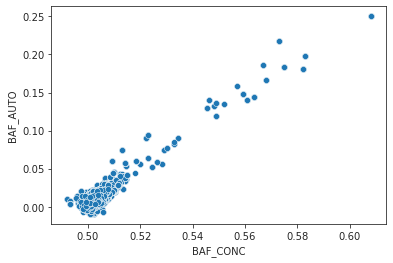

In [7]:
sns.scatterplot(data = df, x="BAF_CONC", y ="BAF_AUTO")

In [8]:
print(np.percentile(df.drop_duplicates(subset='SAMPLE').BAF_CONC, 99))
print(np.percentile(df.drop_duplicates(subset='SAMPLE').BAF_AUTO, 99))

0.5147280000000001
0.05511000000000049


In [9]:
########################################
## Remove possible contamination
########################################

conc_cutoff = 0.51
df_bafconc = df[df.BAF_CONC > conc_cutoff]
df = df[(df.BAF_CONC < conc_cutoff) & (df.BAF_AUTO < 0.03)] # this might change from study to study

df_nhets = df[df.NHETS > -1]

df_blob = df[(df_nhets.LDEV<0.2) & (df_nhets.LDEV > -0.2) & (abs(df_nhets.BDEV) < 0.05)]

sample_count = pd.value_counts(df_blob.SAMPLE)
sample_multicalls = sample_count[sample_count > 1]
sample_twocalls = sample_count[sample_count == 2]
sample_singletons = sample_count[sample_count == 1]

df_blob_multicalls = df_blob[df_blob.SAMPLE.isin(sample_multicalls.index)]
df_blob_singletons = df_blob[df_blob.SAMPLE.isin(sample_singletons.index)]

df['SAMPLE_MULTICALL'] = 0
df.loc[df.SAMPLE.isin(sample_multicalls.index), 'SAMPLE_MULTICALL'] = 1

df_multi = df[df.SAMPLE.isin(sample_multicalls.index)]
df_sing = df[~df.SAMPLE.isin(sample_multicalls.index)]

perc_95 = np.percentile(df.drop_duplicates(subset='SAMPLE').SAMPLE_BAF_SD, 95)
perc_99 = np.percentile(df.drop_duplicates(subset='SAMPLE').SAMPLE_BAF_SD, 99)

perc_95_multi = np.percentile(df[df.SAMPLE_MULTICALL==0].drop_duplicates(subset="SAMPLE").SAMPLE_BAF_SD, 95)
perc_99_multi = np.percentile(df[df.SAMPLE_MULTICALL==0].drop_duplicates(subset="SAMPLE").SAMPLE_BAF_SD, 99)

df['SAMPLE_BAF_SD_FLAG'] = 0
df.loc[df.SAMPLE_BAF_SD > perc_95, 'SAMPLE_BAF_SD_FLAG'] = 1

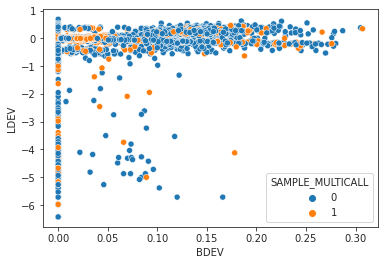

In [10]:
## Plotting the nhets and the blob

ax1= sns.scatterplot(data = df, x = "BDEV", y= "LDEV", hue="SAMPLE_MULTICALL")


In [11]:

###########################################
## Remove CNP calls
############################################

df = df[(df.TYPE != 'CNP Duplication') & (df.TYPE != 'CNP Deletion')]

df.SAMPLE = df.SAMPLE.astype(str)



In [12]:

##########################################
## Annotate 1000G events

##########################################

df_denoise = df.copy()

df_denoise_dup = df_denoise[df_denoise.TYPE == 'Duplication']
df_denoise_del = df_denoise[df_denoise.TYPE == 'Deletion']
df_denoise_loh = df_denoise[df_denoise.TYPE == 'CNN-LOH']
df_denoise_ukn = df_denoise[df_denoise.TYPE == 'Undetermined']

print(len(df_denoise_dup))
print(len(df_denoise_del))
print(len(df_denoise_loh))
print(len(df_denoise_ukn))

df_1KG = pd.read_table("../data/metadata/cnp.grch37.bed", names=['CHR', 'START', 'END','TYPE'])
df_1KG['LENGTH'] = df_1KG.END - df_1KG.START

df_1KG_dup = df_1KG[df_1KG.TYPE == 'DUP']
df_1KG_del = df_1KG[df_1KG.TYPE == 'DEL']
df_1KG_cnv = df_1KG[df_1KG.TYPE == 'CNV']

bed_1kg_dup = pybed.BedTool.from_dataframe(pd.concat([df_1KG_dup, df_1KG_cnv]))
bed_1kg_del = pybed.BedTool.from_dataframe(pd.concat([df_1KG_del, df_1KG_cnv]))
bed_1kg_all = pybed.BedTool.from_dataframe(pd.concat([df_1KG_dup, df_1KG_del, df_1KG_cnv]))

bed_denoise_dup = pybed.BedTool.from_dataframe(df_denoise_dup[['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE', 'LENGTH']])
bed_denoise_del = pybed.BedTool.from_dataframe(df_denoise_del[['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE', 'LENGTH']])
bed_denoise_loh = pybed.BedTool.from_dataframe(df_denoise_loh[['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE', 'LENGTH']])
bed_denoise_ukn = pybed.BedTool.from_dataframe(df_denoise_ukn[['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE', 'LENGTH']])

bed_s_denoise_dup = bed_denoise_dup.intersect(bed_1kg_dup, wao=True)
bed_s_denoise_del = bed_denoise_del.intersect(bed_1kg_del, wao=True)
bed_s_denoise_loh = bed_denoise_loh.intersect(bed_1kg_all, wao=True)
bed_s_denoise_ukn = bed_denoise_ukn.intersect(bed_1kg_all, wao=True)

cols1 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE', 'LENGTH', 'CHROM2', 'BEG_GRCh372', 'END_GRCh372', 'TYPE', 'LENGTH2', 'OVERLAP']
cols2 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE']
cols3 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE', 'OVRLP_1KG']

df_s_denoise_dup = bed_s_denoise_dup.to_dataframe(names=cols1)
df_s_denoise_dup.CHROM = df_s_denoise_dup.CHROM.astype(str)
df_s_denoise_dup.SAMPLE = df_s_denoise_dup.SAMPLE.astype(str)
# df_s_denoise_dup.LENGTH2[df_s_denoise_dup.LENGTH2=='.'] = 1
df_s_denoise_dup.LENGTH2 = df_s_denoise_dup.LENGTH2.astype(int)
df_s_denoise_dup['OVRLP_1KG'] = [min(x, y) for x, y in zip(df_s_denoise_dup.OVERLAP / df_s_denoise_dup.LENGTH, df_s_denoise_dup.OVERLAP / df_s_denoise_dup.LENGTH2)] 
df_smd_dup_merge = df_s_denoise_dup.sort_values('OVRLP_1KG', ascending=False).drop_duplicates(cols2).sort_index()
df_denoise_dup = df_denoise_dup.merge(df_smd_dup_merge[cols3], on=cols2, how='inner')

df_s_denoise_del = bed_s_denoise_del.to_dataframe(names=cols1)
df_s_denoise_del.CHROM = df_s_denoise_del.CHROM.astype(str)
df_s_denoise_del.SAMPLE = df_s_denoise_del.SAMPLE.astype(str)
# # df_s_denoise_del.LENGTH2[df_s_denoise_del.LENGTH2=='.'] = 1
df_s_denoise_del.LENGTH2 = df_s_denoise_del.LENGTH2.astype(int)
df_s_denoise_del['OVRLP_1KG'] = [min(x, y) for x, y in zip(df_s_denoise_del.OVERLAP / df_s_denoise_del.LENGTH, df_s_denoise_del.OVERLAP / df_s_denoise_del.LENGTH2)] 
df_smd_del_merge = df_s_denoise_del.sort_values('OVRLP_1KG', ascending=False).drop_duplicates(cols2).sort_index()
df_denoise_del = df_denoise_del.merge(df_smd_del_merge[cols3], on=cols2, how='inner')

df_s_denoise_loh = bed_s_denoise_loh.to_dataframe(names=cols1)
df_s_denoise_loh.CHROM = df_s_denoise_loh.CHROM.astype(str)
df_s_denoise_loh.SAMPLE = df_s_denoise_loh.SAMPLE.astype(str)
# # df_s_denoise_loh.LENGTH2[df_s_denoise_loh.LENGTH2=='.'] = 1
df_s_denoise_loh.LENGTH2 = df_s_denoise_loh.LENGTH2.astype(int)
df_s_denoise_loh['OVRLP_1KG'] = [min(x, y) for x, y in zip(df_s_denoise_loh.OVERLAP / df_s_denoise_loh.LENGTH, df_s_denoise_loh.OVERLAP / df_s_denoise_loh.LENGTH2)] 
df_smd_loh_merge = df_s_denoise_loh.sort_values('OVRLP_1KG', ascending=False).drop_duplicates(cols2).sort_index()
df_denoise_loh = df_denoise_loh.merge(df_smd_loh_merge[cols3], on=cols2, how='inner')

df_s_denoise_ukn = bed_s_denoise_ukn.to_dataframe(names=cols1)
df_s_denoise_ukn.CHROM = df_s_denoise_ukn.CHROM.astype(str)
df_s_denoise_ukn.SAMPLE = df_s_denoise_ukn.SAMPLE.astype(str)
# # df_s_denoise_ukn.LENGTH2[df_s_denoise_ukn.LENGTH2=='.'] = 1
df_s_denoise_ukn.LENGTH2 = df_s_denoise_ukn.LENGTH2.astype(int)
df_s_denoise_ukn['OVRLP_1KG'] = [min(x, y) for x, y in zip(df_s_denoise_ukn.OVERLAP / df_s_denoise_ukn.LENGTH, df_s_denoise_ukn.OVERLAP / df_s_denoise_ukn.LENGTH2)] 
df_smd_ukn_merge = df_s_denoise_ukn.sort_values('OVRLP_1KG', ascending=False).drop_duplicates(cols2).sort_index()
df_denoise_ukn = df_denoise_ukn.merge(df_smd_ukn_merge[cols3], on=cols2, how='inner')

print(len(df_denoise_dup))
print(len(df_denoise_del))
print(len(df_denoise_loh))
print(len(df_denoise_ukn))

df_denoise = pd.concat([df_denoise_dup, df_denoise_del, df_denoise_loh, df_denoise_ukn])


2956
1962
456
697
2956
1962
456
697


In [13]:

###########################################
## Annotate germline PGC called events
###########################################

df_pgc_raw = pd.read_table("../data/metadata/Illum610K_cnvs_liftoverhg19.bed",names=["CHROM","BEG_GRCh37","END_GRCh37","identifier","TYPE","SCORE","SITES"])

df_pgc = df_pgc_raw[df_pgc_raw.SITES >= 20]
df_pgc['CHROM'].replace(regex=True,inplace=True,to_replace="chr",value="")

df_pgc['LENGTH'] = df_pgc.END_GRCh37 - df_pgc.BEG_GRCh37

df_pgc_dup = df_pgc[df_pgc.TYPE==3]
df_pgc_del = df_pgc[df_pgc.TYPE==1]
df_pgc_ukn = df_pgc[df_pgc.TYPE == -1]  ## conflicting type

bed_pgc_dup = pybed.BedTool.from_dataframe(pd.concat([df_pgc_dup, df_pgc_ukn]))
bed_pgc_del = pybed.BedTool.from_dataframe(pd.concat([df_pgc_del, df_pgc_ukn]))
bed_pgc_all = pybed.BedTool.from_dataframe(pd.concat([df_pgc_dup, df_pgc_del, df_pgc_ukn]))

id_table = met_study.copy()
id_table.set_index('alt_identifier',inplace=True,drop=False)


## Duplications
df_denoise_dup['identifier'] = df_denoise_dup.SAMPLE.astype(str)
df_denoise_dup.identifier = df_denoise_dup.identifier.astype(str)

cols0 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'identifier', 'LENGTH']
cols1 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'identifier', 'LENGTH', 'CHROM2', 'BEG_GRCh372', 'END_GRCh372', 'identifier2', 'LENGTH2', 'OVERLAP']
cols2 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'identifier']
cols3 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'identifier', 'OVRLP_PGC']

l_df_dup = []
print(len(df_denoise_dup.identifier.unique()))
for i, par in enumerate(df_denoise_dup.identifier.unique()):
  if i % 500 == 0:
    print(i)
  df1_dup = df_denoise_dup[(df_denoise_dup.identifier == par)]
  df2_dup = df_pgc_dup[(df_pgc_dup.identifier == par)]
  bed1_dup = pybed.BedTool.from_dataframe(df1_dup[cols0])
  bed2_dup = pybed.BedTool.from_dataframe(df2_dup[cols0])
  bed_s_denoise_dup = bed1_dup.intersect(bed2_dup, wao=True)
  df_s_denoise_dup = bed_s_denoise_dup.to_dataframe(names=cols1)
  df_s_denoise_dup.CHROM = df_s_denoise_dup.CHROM.astype(str)
  if df_s_denoise_dup.LENGTH2.isna().all():
    df_s_denoise_dup['OVRLP_PGC'] = 0
  else:
    df_s_denoise_dup.LENGTH2 = df_s_denoise_dup.LENGTH2.astype(int)
    df_s_denoise_dup['OVRLP_PGC'] = [min(x,y) for x,y in zip(df_s_denoise_dup.OVERLAP / df_s_denoise_dup.LENGTH, df_s_denoise_dup.OVERLAP / df_s_denoise_dup.LENGTH2)]
  df_sdenoise_dup_merge = df_s_denoise_dup.sort_values('OVRLP_PGC', ascending=False).drop_duplicates(cols2).sort_index()
  df_sdenoise_dup_merge.identifier = df_sdenoise_dup_merge.identifier.astype(str)
  df1_dup = df1_dup.merge(df_sdenoise_dup_merge[cols3],on=cols2,how="inner")
  l_df_dup.append(df1_dup)


df_tmp_dup = pd.concat(l_df_dup)
df_denoise_dup = df_denoise_dup.merge(df_tmp_dup[cols3], on=cols2, how="inner")

## Deletions

df_denoise_del['identifier']= df_denoise_del.SAMPLE.astype(str)
df_denoise_del.identifier = df_denoise_del.identifier.astype(str)
l_df_del = []
print(len(df_denoise_del.identifier.unique()))
for i, par in enumerate(df_denoise_del.identifier.unique()):
  if i % 500 == 0:
    print(i)
  df1_del = df_denoise_del[(df_denoise_del.identifier == par)]
  df2_del = df_pgc_del[(df_pgc_del.identifier == par)]
  bed1_del = pybed.BedTool.from_dataframe(df1_del[cols0])
  bed2_del = pybed.BedTool.from_dataframe(df2_del[cols0])
  bed_s_denoise_del = bed1_del.intersect(bed2_del, wao=True)
  df_s_denoise_del = bed_s_denoise_del.to_dataframe(names=cols1)
  df_s_denoise_del.CHROM = df_s_denoise_del.CHROM.astype(str)
  if df_s_denoise_del.LENGTH2.isna().all():
    df_s_denoise_del['OVRLP_PGC'] = 0
  else:
    df_s_denoise_del.LENGTH2 = df_s_denoise_del.LENGTH2.astype(int)
    df_s_denoise_del['OVRLP_PGC'] = [min(x,y) for x,y in zip(df_s_denoise_del.OVERLAP / df_s_denoise_del.LENGTH, df_s_denoise_del.OVERLAP / df_s_denoise_del.LENGTH2)]
  df_sdenoise_del_merge = df_s_denoise_del.sort_values('OVRLP_PGC', ascending=False).drop_duplicates(cols2).sort_index()
  df_sdenoise_del_merge.identifier = df_sdenoise_del_merge.identifier.astype(str)
  df1_del = df1_del.merge(df_sdenoise_del_merge[cols3],on=cols2,how="inner")
  l_df_del.append(df1_del)


df_tmp_del = pd.concat(l_df_del)
df_denoise_del = df_denoise_del.merge(df_tmp_del[cols3], on=cols2, how="inner")


## CNN-LOH
df_denoise_loh['identifier'] = df_denoise_loh.SAMPLE.astype(str)
df_denoise_loh.identifier = df_denoise_loh.identifier.astype(str)
df_denoise_loh['OVRLP_PGC'] = 0


df_denoise_ukn['identifier'] = df_denoise_ukn.SAMPLE.astype(str)
df_denoise_ukn.identifier = df_denoise_ukn.identifier.astype(str)
df_denoise_ukn['OVRLP_PGC'] = 0

df_denoise = pd.concat([df_denoise_dup, df_denoise_del, df_denoise_loh, df_denoise_ukn])

/home/emauryg/anaconda3/envs/bsmn3/lib/python3.6/site-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/emauryg/anaconda3/envs/bsmn3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


1874
0
500
1000
1500
1319
0
500
1000


In [14]:
df_denoise.shape

(6071, 34)

In [15]:

####################################
## Split into disease and control
####################################

df_dx = df_denoise[(df_denoise.SAMPLE.isin(met_dx.alt_identifier)
) | (df_denoise.SAMPLE.isin(met_dx.identifier))]
df_ctrl = df_denoise[(df_denoise.SAMPLE.isin(met_ctrl.alt_identifier)) | (df_denoise.SAMPLE.isin(met_ctrl.identifier))]



##############################################################
## Annotate CNVs that overlap with controls significantly
##############################################################

SIZE_CUTOFF=10000000

cols0 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE', 'LENGTH']
cols1 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE', 'LENGTH', 'CHROM2', 'BEG_GRCh372', 'END_GRCh372', 'SAMPLE2', 'LENGTH2', 'OVERLAP']
cols2 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE']
cols3 = ['CHROM', 'BEG_GRCh37', 'END_GRCh37', 'SAMPLE', 'OVRLP_CONTROL']

df_ctrl_dup = df_ctrl[df_ctrl.TYPE=="Duplication"]
df_ctrl_del = df_ctrl[df_ctrl.TYPE=="Deletion"]
df_ctrl_loh = df_ctrl[df_ctrl.TYPE=="CNN-LOH"]
df_ctrl_ukn = df_ctrl[df_ctrl.TYPE=="Undetermined"]

print(len(df_ctrl_dup))
print(len(df_ctrl_del))
print(len(df_ctrl_loh))
print(len(df_ctrl_ukn))


## Annotate control events
l_df_dup = []
print(len(df_ctrl_dup.SAMPLE.unique()))
for i, par in enumerate(df_ctrl_dup.SAMPLE.unique()):
  if i % 500 == 0:
    print(i)
  df1_dup = df_ctrl_dup[(df_ctrl_dup.SAMPLE== par)]
  df2_dup = df_ctrl_dup[(df_ctrl_dup.SAMPLE != par) & (df_ctrl_dup.LENGTH < SIZE_CUTOFF)]
  bed1_dup = pybed.BedTool.from_dataframe(df1_dup[cols0])
  bed2_dup = pybed.BedTool.from_dataframe(df2_dup[cols0])
  bed_s_ctrl_dup = bed1_dup.intersect(bed2_dup, wao=True)
  df_s_ctrl_dup = bed_s_ctrl_dup.to_dataframe(names=cols1)
  df_s_ctrl_dup.CHROM = df_s_ctrl_dup.CHROM.astype(str)
  df_s_ctrl_dup.LENGTH2 = df_s_ctrl_dup.LENGTH2.astype(int)
  df_s_ctrl_dup['OVRLP_CONTROL'] = [min(x,y) for x,y in zip(df_s_ctrl_dup.OVERLAP / df_s_ctrl_dup.LENGTH, df_s_ctrl_dup.OVERLAP / df_s_ctrl_dup.LENGTH2)]
  df_sctrl_dup_merge = df_s_ctrl_dup.sort_values('OVRLP_CONTROL', ascending=False).drop_duplicates(cols2).sort_index()
  df_sctrl_dup_merge.SAMPLE = df_sctrl_dup_merge.SAMPLE.astype(str)
  df1_dup = df1_dup.merge(df_sctrl_dup_merge[cols3],on=cols2,how="inner")
  l_df_dup.append(df1_dup)


df_tmp_dup = pd.concat(l_df_dup)
df_ctrl_dup = df_ctrl_dup.merge(df_tmp_dup[cols3], on=cols2, how="inner")

l_df_del = []
print(len(df_ctrl_del.SAMPLE.unique()))
for i, par in enumerate(df_ctrl_del.SAMPLE.unique()):
  if i % 500 == 0:
    print(i)
  df1_del = df_ctrl_del[(df_ctrl_del.SAMPLE== par)]
  df2_del = df_ctrl_del[(df_ctrl_del.SAMPLE != par) & (df_ctrl_del.LENGTH < SIZE_CUTOFF)]
  bed1_del = pybed.BedTool.from_dataframe(df1_del[cols0])
  bed2_del = pybed.BedTool.from_dataframe(df2_del[cols0])
  bed_s_ctrl_del = bed1_del.intersect(bed2_del, wao=True)
  df_s_ctrl_del = bed_s_ctrl_del.to_dataframe(names=cols1)
  df_s_ctrl_del.CHROM = df_s_ctrl_del.CHROM.astype(str)
  df_s_ctrl_del.LENGTH2 = df_s_ctrl_del.LENGTH2.astype(int)
  df_s_ctrl_del['OVRLP_CONTROL'] = [min(x,y) for x,y in zip(df_s_ctrl_del.OVERLAP / df_s_ctrl_del.LENGTH, df_s_ctrl_del.OVERLAP / df_s_ctrl_del.LENGTH2)]
  df_sctrl_del_merge = df_s_ctrl_del.sort_values('OVRLP_CONTROL', ascending=False).drop_duplicates(cols2).sort_index()
  df_sctrl_del_merge.SAMPLE = df_sctrl_del_merge.SAMPLE.astype(str)
  df1_del = df1_del.merge(df_sctrl_del_merge[cols3],on=cols2,how="inner")
  l_df_del.append(df1_del)


df_tmp_del = pd.concat(l_df_del)
df_ctrl_del = df_ctrl_del.merge(df_tmp_del[cols3], on=cols2, how="inner")

l_df_loh = []
print(len(df_ctrl_loh.SAMPLE.unique()))
for i, par in enumerate(df_ctrl_loh.SAMPLE.unique()):
  if i % 500 == 0:
    print(i)
  df1_loh = df_ctrl_loh[(df_ctrl_loh.SAMPLE== par)]
  df2_loh = df_ctrl_loh[(df_ctrl_loh.SAMPLE != par) & (df_ctrl_loh.LENGTH < SIZE_CUTOFF)]
  bed1_loh = pybed.BedTool.from_dataframe(df1_loh[cols0])
  bed2_loh = pybed.BedTool.from_dataframe(df2_loh[cols0])
  bed_s_ctrl_loh = bed1_loh.intersect(bed2_loh, wao=True)
  df_s_ctrl_loh = bed_s_ctrl_loh.to_dataframe(names=cols1)
  df_s_ctrl_loh.CHROM = df_s_ctrl_loh.CHROM.astype(str)
  df_s_ctrl_loh.LENGTH2 = df_s_ctrl_loh.LENGTH2.astype(int)
  df_s_ctrl_loh['OVRLP_CONTROL'] = [min(x,y) for x,y in zip(df_s_ctrl_loh.OVERLAP / df_s_ctrl_loh.LENGTH, df_s_ctrl_loh.OVERLAP / df_s_ctrl_loh.LENGTH2)]
  df_sctrl_loh_merge = df_s_ctrl_loh.sort_values('OVRLP_CONTROL', ascending=False).drop_duplicates(cols2).sort_index()
  df_sctrl_loh_merge.SAMPLE = df_sctrl_loh_merge.SAMPLE.astype(str)
  df1_loh = df1_loh.merge(df_sctrl_loh_merge[cols3],on=cols2,how="inner")
  l_df_loh.append(df1_loh)


df_tmp_loh = pd.concat(l_df_loh)
df_ctrl_loh = df_ctrl_loh.merge(df_tmp_loh[cols3], on=cols2, how="inner")

l_df_ukn = []
print(len(df_ctrl_ukn.SAMPLE.unique()))
for i, par in enumerate(df_ctrl_ukn.SAMPLE.unique()):
  if i % 500 == 0:
    print(i)
  df1_ukn = df_ctrl_ukn[(df_ctrl_ukn.SAMPLE== par)]
  df2_ukn = df_ctrl_ukn[(df_ctrl_ukn.SAMPLE != par)& (df_ctrl_ukn.LENGTH < SIZE_CUTOFF)]
  bed1_ukn = pybed.BedTool.from_dataframe(df1_ukn[cols0])
  bed2_ukn = pybed.BedTool.from_dataframe(df2_ukn[cols0])
  bed_s_ctrl_ukn = bed1_ukn.intersect(bed2_ukn, wao=True)
  df_s_ctrl_ukn = bed_s_ctrl_ukn.to_dataframe(names=cols1)
  df_s_ctrl_ukn.CHROM = df_s_ctrl_ukn.CHROM.astype(str)
  df_s_ctrl_ukn.LENGTH2 = df_s_ctrl_ukn.LENGTH2.astype(int)
  df_s_ctrl_ukn['OVRLP_CONTROL'] = [min(x,y) for x,y in zip(df_s_ctrl_ukn.OVERLAP / df_s_ctrl_ukn.LENGTH, df_s_ctrl_ukn.OVERLAP / df_s_ctrl_ukn.LENGTH2)]
  df_sctrl_ukn_merge = df_s_ctrl_ukn.sort_values('OVRLP_CONTROL', ascending=False).drop_duplicates(cols2).sort_index()
  df_sctrl_ukn_merge.SAMPLE = df_sctrl_ukn_merge.SAMPLE.astype(str)
  df1_ukn = df1_ukn.merge(df_sctrl_ukn_merge[cols3],on=cols2,how="inner")
  l_df_ukn.append(df1_ukn)


df_tmp_ukn = pd.concat(l_df_ukn)
df_ctrl_ukn = df_ctrl_ukn.merge(df_tmp_ukn[cols3], on=cols2, how="inner")

## Annotate disease events

df_dx_dup = df_dx[df_dx.TYPE=="Duplication"]
df_dx_del = df_dx[df_dx.TYPE=="Deletion"]
df_dx_loh = df_dx[df_dx.TYPE=="CNN-LOH"]
df_dx_ukn = df_dx[df_dx.TYPE=="Undetermined"]

print(len(df_dx_dup))
print(len(df_dx_del))
print(len(df_dx_loh))
print(len(df_dx_ukn))

df_dx_pos = pd.concat([df_dx_dup, df_dx_loh, df_dx_ukn])
df_dx_neg = pd.concat([df_dx_del, df_dx_loh, df_dx_ukn])

l_df_dup = []
print(len(df_dx_dup.SAMPLE.unique()))
for i, par in enumerate(df_dx_dup.SAMPLE.unique()):
  if i % 500 == 0:
    print(i)
  df1_dup = df_dx_dup[(df_dx_dup.SAMPLE== par)]
  df2_dup = df_ctrl_dup[(df_ctrl_dup.LENGTH < SIZE_CUTOFF)]
  bed1_dup = pybed.BedTool.from_dataframe(df1_dup[cols0])
  bed2_dup = pybed.BedTool.from_dataframe(df2_dup[cols0])
  bed_s_dx_dup = bed1_dup.intersect(bed2_dup, wao=True)
  df_s_dx_dup = bed_s_dx_dup.to_dataframe(names=cols1)
  df_s_dx_dup.CHROM = df_s_dx_dup.CHROM.astype(str)
  df_s_dx_dup.LENGTH2 = df_s_dx_dup.LENGTH2.astype(int)
  df_s_dx_dup['OVRLP_CONTROL'] = [min(x,y) for x,y in zip(df_s_dx_dup.OVERLAP / df_s_dx_dup.LENGTH, df_s_dx_dup.OVERLAP / df_s_dx_dup.LENGTH2)]
  df_sdx_dup_merge = df_s_dx_dup.sort_values('OVRLP_CONTROL', ascending=False).drop_duplicates(cols2).sort_index()
  df_sdx_dup_merge.SAMPLE = df_sdx_dup_merge.SAMPLE.astype(str)
  df1_dup = df1_dup.merge(df_sdx_dup_merge[cols3],on=cols2,how="inner")
  l_df_dup.append(df1_dup)


df_tmp_dup = pd.concat(l_df_dup)
df_dx_dup = df_dx_dup.merge(df_tmp_dup[cols3], on=cols2, how="inner")

l_df_del = []
print(len(df_dx_del.SAMPLE.unique()))
for i, par in enumerate(df_dx_del.SAMPLE.unique()):
  if i % 500 == 0:
    print(i)
  df1_del = df_dx_del[(df_dx_del.SAMPLE== par)]
  df2_del = df_ctrl_del[(df_ctrl_del.LENGTH < SIZE_CUTOFF)]
  bed1_del = pybed.BedTool.from_dataframe(df1_del[cols0])
  bed2_del = pybed.BedTool.from_dataframe(df2_del[cols0])
  bed_s_dx_del = bed1_del.intersect(bed2_del, wao=True)
  df_s_dx_del = bed_s_dx_del.to_dataframe(names=cols1)
  df_s_dx_del.CHROM = df_s_dx_del.CHROM.astype(str)
  df_s_dx_del.LENGTH2 = df_s_dx_del.LENGTH2.astype(int)
  df_s_dx_del['OVRLP_CONTROL'] = [min(x,y) for x,y in zip(df_s_dx_del.OVERLAP / df_s_dx_del.LENGTH, df_s_dx_del.OVERLAP / df_s_dx_del.LENGTH2)]
  df_sdx_del_merge = df_s_dx_del.sort_values('OVRLP_CONTROL', ascending=False).drop_duplicates(cols2).sort_index()
  df_sdx_del_merge.SAMPLE = df_sdx_del_merge.SAMPLE.astype(str)
  df1_del = df1_del.merge(df_sdx_del_merge[cols3],on=cols2,how="inner")
  l_df_del.append(df1_del)


df_tmp_del = pd.concat(l_df_del)
df_dx_del = df_dx_del.merge(df_tmp_del[cols3], on=cols2, how="inner")

l_df_loh = []
print(len(df_dx_loh.SAMPLE.unique()))
for i, par in enumerate(df_dx_loh.SAMPLE.unique()):
  if i % 500 == 0:
    print(i)
  df1_loh = df_dx_loh[(df_dx_loh.SAMPLE== par)]
  df2_loh = df_ctrl_loh[(df_ctrl_loh.LENGTH < SIZE_CUTOFF)]
  bed1_loh = pybed.BedTool.from_dataframe(df1_loh[cols0])
  bed2_loh = pybed.BedTool.from_dataframe(df2_loh[cols0])
  bed_s_dx_loh = bed1_loh.intersect(bed2_loh, wao=True)
  df_s_dx_loh = bed_s_dx_loh.to_dataframe(names=cols1)
  df_s_dx_loh.CHROM = df_s_dx_loh.CHROM.astype(str)
  df_s_dx_loh.LENGTH2 = df_s_dx_loh.LENGTH2.astype(int)
  df_s_dx_loh['OVRLP_CONTROL'] = [min(x,y) for x,y in zip(df_s_dx_loh.OVERLAP / df_s_dx_loh.LENGTH, df_s_dx_loh.OVERLAP / df_s_dx_loh.LENGTH2)]
  df_sdx_loh_merge = df_s_dx_loh.sort_values('OVRLP_CONTROL', ascending=False).drop_duplicates(cols2).sort_index()
  df_sdx_loh_merge.SAMPLE = df_sdx_loh_merge.SAMPLE.astype(str)
  df1_loh = df1_loh.merge(df_sdx_loh_merge[cols3],on=cols2,how="inner")
  l_df_loh.append(df1_loh)


df_tmp_loh = pd.concat(l_df_loh)
df_dx_loh = df_dx_loh.merge(df_tmp_loh[cols3], on=cols2, how="inner")

l_df_ukn = []
print(len(df_dx_ukn.SAMPLE.unique()))
for i, par in enumerate(df_dx_ukn.SAMPLE.unique()):
  if i % 500 == 0:
    print(i)
  df1_ukn = df_dx_ukn[(df_dx_ukn.SAMPLE== par)]
  df2_ukn = df_ctrl_ukn[(df_ctrl_ukn.LENGTH < SIZE_CUTOFF)]
  bed1_ukn = pybed.BedTool.from_dataframe(df1_ukn[cols0])
  bed2_ukn = pybed.BedTool.from_dataframe(df2_ukn[cols0])
  bed_s_dx_ukn = bed1_ukn.intersect(bed2_ukn, wao=True)
  df_s_dx_ukn = bed_s_dx_ukn.to_dataframe(names=cols1)
  df_s_dx_ukn.CHROM = df_s_dx_ukn.CHROM.astype(str)
  df_s_dx_ukn.LENGTH2 = df_s_dx_ukn.LENGTH2.astype(int)
  df_s_dx_ukn['OVRLP_CONTROL'] = [min(x,y) for x,y in zip(df_s_dx_ukn.OVERLAP / df_s_dx_ukn.LENGTH, df_s_dx_ukn.OVERLAP / df_s_dx_ukn.LENGTH2)]
  df_sdx_ukn_merge = df_s_dx_ukn.sort_values('OVRLP_CONTROL', ascending=False).drop_duplicates(cols2).sort_index()
  df_sdx_ukn_merge.SAMPLE = df_sdx_ukn_merge.SAMPLE.astype(str)
  df1_ukn = df1_ukn.merge(df_sdx_ukn_merge[cols3],on=cols2,how="inner")
  l_df_ukn.append(df1_ukn)


df_tmp_ukn = pd.concat(l_df_ukn)
df_dx_ukn = df_dx_ukn.merge(df_tmp_ukn[cols3], on=cols2, how="inner")

df_dx_all = pd.concat([df_dx_dup,df_dx_del,df_dx_loh,df_dx_ukn])
df_ctrl_all = pd.concat([df_ctrl_dup, df_ctrl_del, df_ctrl_loh, df_ctrl_ukn])


1399
899
244
356
882
0
500
584
0
500
188
0
283
0
1557
1063
212
341
992
0
500
735
0
500
156
0
275
0


In [16]:
df_denoise = pd.concat([df_dx_all,df_ctrl_all])
print(df_denoise.shape)

(6071, 35)


In [17]:
## Annotate with call_rate

df_denoise['CALL_RATE'] = stats.loc[df_denoise.SAMPLE,'CALL_RATE'].values



<AxesSubplot:xlabel='CALL_RATE', ylabel='Count'>

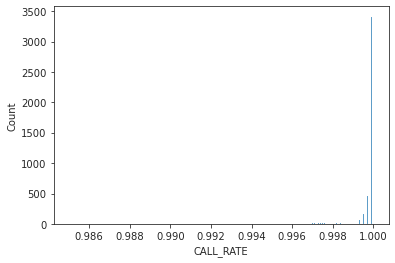

In [18]:
sns.histplot(df_denoise.CALL_RATE)

In [19]:


from utils.vcf_tools_eam0 import *

nhets=20
overlap_control = 0.50
overlap_1kg = 0.50
overlap_pgc = 0.50
baf_cutoff = 0.08

df_private = df_denoise[(df_denoise.OVRLP_1KG < overlap_1kg) & (df_denoise.OVRLP_CONTROL < overlap_control) & (df_denoise.SAMPLE_MULTICALL ==0) & (df_denoise.SAMPLE_BAF_SD_FLAG==0) & (df_denoise.OVRLP_PGC < overlap_pgc) & (df_denoise.FailedQC==0)]

df_nhet = df_private[(df_private.NHETS > nhets) & (df_private.CF < 1) & (df_private.CHROM !="X")]

df_nhet_no9 = df_nhet[~((df_nhet.CHROM=="9") & (df_nhet['BEG_GRCh37'] > 1.3e8) & (df_nhet.TYPE=='Deletion'))]
df_retype = df_nhet_no9[['BDEV','LDEV','NHETS','TYPE','P_ARM','Q_ARM']].copy()
b_dup_em, b_del_em, s_dup_em, s_del_em, s_loh_em = em_run_ML(df_retype)

CLASS = em_assign_ML3(df_denoise, b_dup_em, b_del_em, s_dup_em,s_del_em, s_loh_em)
# df_denoise['LRT'] = scipy.stats.chi2.sf(-2*np.log(df_denoise.p_LOH / df_denoise[['p_DUP','p_DEL','p_LOH']].max(axis=1)),1)
normalized_posterior = np.sum(df_denoise[['p_DUP','p_DEL','p_LOH']],axis=1)
df_denoise['Posterior'] = df_denoise[['p_DUP','p_DEL','p_LOH']].max(axis=1)/normalized_posterior
df_denoise.loc[df_denoise.Posterior.isna(),'Posterior'] = 0 
df_denoise['RETYPE'] = CLASS

df_denoise.loc[(df_denoise.p_DUP==0) & (df_denoise.p_DEL == 0) & (df_denoise.p_LOH==0),'RETYPE'] = 'UKN'



df_denoise['label'] = 'non-SCZ'
df_denoise.loc[df_denoise.SAMPLE.isin(met_dx.alt_identifier),'label'] = 'SCZ'
df_denoise.loc[df_denoise.SAMPLE.isin(met_ctrl.alt_identifier),'label'] = 'ctrl'



0
1


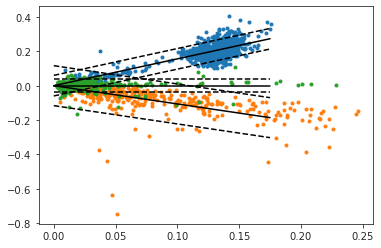

In [20]:
df_somatic = df_denoise[(df_denoise.NHETS >= 20)  &(df_denoise.CHROM != "X") & (df_denoise.LDEV > -1)].copy()


df_md_all = df_somatic.copy()
#df_md_all = df_somatic[df_somatic.arrayName=="IllumOmniExpress"]


f,ax = plt.subplots(1,1)
plt.plot(df_md_all[df_md_all.RETYPE == 'DUP'].BDEV, df_md_all[df_md_all.RETYPE == 'DUP'].LDEV, '.')
plt.plot(df_md_all[df_md_all.RETYPE == 'DEL'].BDEV, df_md_all[df_md_all.RETYPE == 'DEL'].LDEV, '.')
plt.plot(df_md_all[df_md_all.RETYPE == 'CNN-LOH'].BDEV, df_md_all[df_md_all.RETYPE == 'CNN-LOH'].LDEV, '.')
plt.plot(df_md_all[df_md_all.RETYPE == 'UKN'].BDEV, df_md_all[df_md_all.RETYPE == 'UKN'].LDEV, '.')

plt.plot((0, 0.175), (0, 0.175*0), color='k')
plt.plot((0, 0.175), (0+2*s_loh_em, 0.175*0.+2*s_loh_em),'--', color='k')
plt.plot((0, 0.175), (0-2*s_loh_em, 0.175*0.-2*s_loh_em), '--', color='k')

plt.plot((0, 0.175), (0, 0.175*b_dup_em), color='k')
plt.plot((0, 0.175), (0+2*s_dup_em, 0.175*b_dup_em+2*s_dup_em),'--', color='k')
plt.plot((0, 0.175), (0-2*s_dup_em, 0.175*b_dup_em-2*s_dup_em), '--', color='k')

plt.plot((0, 0.175), (0, 0.175*b_del_em), color='k')
plt.plot((0, 0.175), (0+2*s_del_em, 0.175*b_del_em+2*s_del_em),'--', color='k')
plt.plot((0, 0.175), (0-2*s_del_em, 0.175*b_del_em-2*s_del_em), '--', color='k')

In [21]:
df_denoise.shape

(6071, 42)

In [23]:
#######################################
## Save file
#######################################
df_denoise.to_csv('../data/annotated_calls/{}_annot_retype.txt'.format(studyName),#
 sep="\t", index=False)